In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/homes/sjanssen/.ggmaprc'
ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/homes/sjanssen/.ggmaprc'


In [113]:
meta = pd.read_excel('Incoming/BMT_Pax5+- microbiome metadata.xlsx', skiprows=2, skipfooter=3, header=None)

host = meta.iloc[1:,:11]
# downfill cage info
host.iloc[2:,col_idx] = host.iloc[2:,col_idx].fillna(method='ffill')

# remove empty line
host.drop(2, inplace=True)

# make first row column headers
host.columns = host.iloc[0,:]
host.drop(1, inplace=True)
del host['Age']

samples = []
for x in [11,17,22, 27,32,]: #11
    tp = meta.iloc[:, x:x+5]
    tp['time'] = tp.iloc[0,0]
    tp['time'].iloc[2] = 'time'
    tp.columns = tp.iloc[2,:]
    tp.drop([0,1,2], inplace=True)
    tp['host_subject_id'] = host['Recipient Mouse ID']
    # drop lines for dead mice
    tp = tp[pd.notna(tp['DATE'])]
    samples.append(tp)
samples = pd.concat(samples)
#samples['host_age'] = samples['DATE'] - samples['']
meta = samples.merge(host, left_on='host_subject_id', right_on='Recipient Mouse ID', how='left')

meta['host_age'] = (meta['DATE'] - meta['Date of birth']).apply(lambda x: int(x.days))
meta['host_age_unit'] = 'days'
del meta['AGE (Months)']

# fix column headers
meta = meta.rename(columns={
    'DATE': 'collection_timestamp',
    'Stool DNA(location)': 'stool_dna_location',
    'Stool weight (g)': 'weight_stool',
    'Stool DNA ng/ul': 'stool_dna_concentration',
    'Mouse number': 'mouse_number',
    'Mouse identification': 'mouse_identification',
    #'Recipient Mouse ID': 'host_subject_id',
    'Genotipe': 'genotype',
    'Date of birth': 'birth_timestamp',
    'Donor  mouse ID': 'donor_genotype',
    'SEX': 'sex',
    'Date of BMT': 'bone_marrow_transplant_timestamp',
    'Date of death': 'death_timestamp',
    np.nan: 'cage',
})
meta['weight_stool_units'] = 'grams'
meta['stool_dna_concentration_units'] = 'ng/ul'
meta['timepoint_title'] = meta['time'].apply(lambda x: x[4:])
meta['timepoint_weeks'] = meta['time'].apply(lambda x: int(x.split(' ')[2]))
del meta['time']
del meta['Recipient Mouse ID']
meta['donor_genotype'] = meta['donor_genotype'].apply(lambda x: x.rstrip())

meta

,collection_timestamp,stool_dna_location,weight_stool,stool_dna_concentration,host_subject_id,cage,mouse_number,mouse_identification,genotype,birth_timestamp,donor_genotype,sex,bone_marrow_transplant_timestamp,death_timestamp,host_age,host_age_unit,weight_stool_units,stool_dna_concentration_units,timepoint_title,timepoint_weeks
0,2020-01-17 00:00:00,Box1- 5,0.1332,45.6,WT-5,CAGE-2,5,1,WT-BMT-Pax5+/-,2019-12-10 00:00:00,Pax5+/-,Female,2020-01-17 00:00:00,NaN,38,days,grams,ng/ul,0 (before BMT),0
1,2020-01-17 00:00:00,Box1- 6,0.1471,100.7,WT-6,CAGE-2,6,2,WT-BMT-Pax5+/-,2019-12-10 00:00:00,Pax5+/-,Female,2020-01-17 00:00:00,2020-03-13 00:00:00,38,days,grams,ng/ul,0 (before BMT),0
2,2020-01-17 00:00:00,Box1- 7,0.1463,62.2,WT-7,CAGE-2,7,3,WT-BMT-Pax5+/-,2019-12-10 00:00:00,Pax5+/-,Female,2020-01-17 00:00:00,NaN,38,days,grams,ng/ul,0 (before BMT),0
3,2020-01-17 00:00:00,Box1- 8,0.1396,58.4,WT-8,CAGE-2,8,7,WT-BMT-Pax5+/-,2019-12-10 00:00:00,Pax5+/-,Female,2020-01-17 00:00:00,NaN,38,days,grams,ng/ul,0 (before BMT),0
4,2020-01-17 00:00:00,Box1- 10,0.1383,19.9,WT-10,CAGE-2,10,1N,WT-BMT-Pax5+/-,2019-12-10 00:00:00,Pax5+/-,Female,2020-01-17 00:00:00,2020-02-18 00:00:00,38,days,grams,ng/ul,0 (before BMT),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2020-04-10 00:00:00,NaN,NaN,NaN,WT-28,CAGE-6,28,SMN,WT-BMT-WT,2020-01-03 00:00:00,WT,Female,2020-02-14 00:00:00,NaN,98,days,grams,ng/ul,8 weeks after BMT,8
88,2020-04-24 00:00:00,NaN,NaN,NaN,WT-30,CAGE-7,30,2N,WT-BMT-Pax5+/-,2020-01-16 00:00:00,Pax5+/-,Female,2020-02-28 00:00:00,NaN,99,days,grams,ng/ul,8 weeks after BMT,8
89,2020-04-24 00:00:00,NaN,NaN,NaN,WT-31,CAGE-7,31,1,WT-BMT-Pax5+/-,2020-01-23 00:00:00,Pax5+/-,Female,2020-02-28 00:00:00,NaN,92,days,grams,ng/ul,8 weeks after BMT,8
90,2020-04-24 00:00:00,NaN,NaN,NaN,WT-32,CAGE-7,32,SM,WT-BMT-Pax5+/-,2020-01-23 00:00:00,Pax5+/-,Female,2020-02-28 00:00:00,NaN,92,days,grams,ng/ul,8 weeks after BMT,8


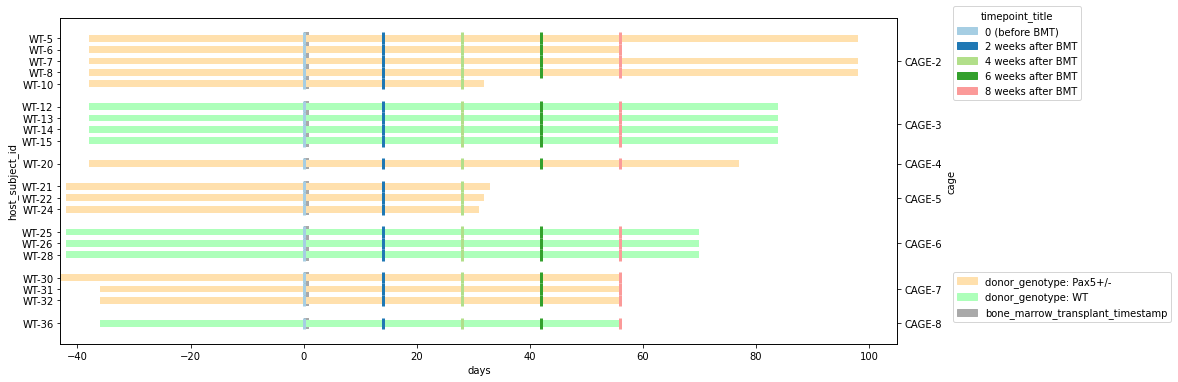

In [157]:
meta_help = meta.copy()
meta_help['bone_marrow_transplant_timestamp_END'] = meta_help['bone_marrow_transplant_timestamp'] + pd.DateOffset(days=1)
ganttChart(meta_help, col_birth='birth_timestamp', col_entities='host_subject_id', col_events='collection_timestamp',
           col_death='death_timestamp', col_events_title='timepoint_title', col_entity_groups='cage',
           col_entity_colors='donor_genotype', order_entities=list(host['Recipient Mouse ID'].values),
           col_phases_start=['bone_marrow_transplant_timestamp'], col_phases_end=['bone_marrow_transplant_timestamp_END'],
           colors_entities={'Pax5+/-': '#ffe0ad', 'WT': '#adffba'}, event_line_width=3,
           colors_phases={'bone_marrow_transplant_timestamp': 'darkgray'},
           align_to_event_title='0 (before BMT)')[0]